In [1]:
# All necessary imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from raw_data_handler import Raw_Data_Handler
from dataset_design import Dataset_Designer
from feature_extractor import Feature_Extractor
import pandas as pd

In [2]:
# Data Pipeline

# Raw Data Handler
rdh = Raw_Data_Handler()
e, x, t = rdh.extract('customer_release.csv', 
                      'transactions_release.parquet', 
                      'fraud_release.json')
transformed = rdh.transform(e, x, t)
rdh.load(output_filename=r'output_data.parquet')

Transposing fraud_information to align with transaction_information
No common column names found between fraud and trans data. Reverting to specific approach.
Data successfully saved to output_data.parquet


In [3]:
# Dataset Designer
dsd = Dataset_Designer(test_size=0.2, target_column_name='fraudulence')
extracted = dsd.extract('output_data.parquet')
partitioned = dsd.sample(extracted)
dsd.load('partitioned.parquet')

No overlap in cc_num values between training and testing sets.
Data successfully saved to partitioned.parquet


In [4]:
# Feature Extractor
fe = Feature_Extractor(target_column_name='fraudulence')
train, test = fe.extract('partitioned.parquet')
fe_trans = fe.transform(train, test)
fe_trans[0]

Number of NaN values in target before processing:
Training: 131913
Testing: 32757

Number of NaN values in target after dropping:
Training: 0
Testing: 0

No overlap in cc_num values between training and testing sets.

Final check for NaN values in transformed training data:
unix_time                0
merchant                 0
amt                      0
merch_lat                0
merch_long               0
transaction_hour         0
time_since_last_trans    0
fraudulence              0
dtype: int64

Final check for NaN values in transformed testing data:
unix_time                0
merchant                 0
amt                      0
merch_lat                0
merch_long               0
transaction_hour         0
time_since_last_trans    0
fraudulence              0
dtype: int64


,unix_time,merchant,amt,merch_lat,merch_long,transaction_hour,time_since_last_trans,fraudulence
1,-1.822971,0.001860,-0.108314,0.677462,-1.266781,8,21.676214,0.0
2,-1.822962,0.001808,0.077959,0.861594,-1.274769,8,-0.617090,0.0
4,-1.822094,0.001682,-0.272981,0.932001,-1.199639,13,-0.317730,0.0
5,-1.817193,0.099977,-0.402809,0.962392,-1.296579,13,1.087220,0.0
6,-1.816571,0.001252,-0.392837,0.844040,-1.274960,17,-0.403434,0.0
...,...,...,...,...,...,...,...,...
1320636,1.638528,0.001839,-0.024127,0.461954,0.158981,2,-0.465447,0.0
1320637,1.639133,0.000845,-0.417448,0.407627,0.083305,5,-0.409371,0.0
1320638,1.640328,0.001905,0.166685,0.452991,0.140624,11,-0.203988,0.0
1320639,1.640334,0.001698,0.508803,0.563856,0.065576,11,-0.618201,0.0


In [5]:
fe_trans[1][fe_trans[1]['fraudulence'] == 1]

,unix_time,merchant,amt,merch_lat,merch_long,transaction_hour,time_since_last_trans,fraudulence
1320731,-1.325253,0.001720,1.401366,-0.761622,-0.543184,3,0.621853,1.0
1320732,-1.325188,0.001736,1.523716,-0.686250,-0.507421,3,-0.597325,1.0
1320733,-1.324867,0.001808,-0.390089,-0.478160,-0.591943,5,-0.508404,1.0
1320734,-1.321941,0.000877,4.202556,-0.619224,-0.624937,20,0.398946,1.0
1320736,-1.321302,0.001355,6.238070,-0.501979,-0.577427,23,-0.397458,1.0
...,...,...,...,...,...,...,...,...
1647225,1.282400,0.001676,1.380208,0.017054,0.998413,2,-0.348985,1.0
1647226,1.286265,0.001350,5.690822,0.220774,0.980857,22,0.726057,1.0
1647227,1.286353,0.001627,6.334915,0.214199,1.029637,22,-0.589243,1.0
1647228,1.290009,0.001582,5.248472,-0.057644,0.951244,17,0.653261,1.0


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [7]:
train_transformed = fe_trans[0]
test_transformed = fe_trans[1]

# Separate features and target
X_train_full = train_transformed.drop(columns=['fraudulence'])
Y_train_full = train_transformed['fraudulence']
X_test_full = test_transformed.drop(columns=['fraudulence'])
Y_test_full = test_transformed['fraudulence']

In [8]:
# Define the fraction of data to sample (e.g., 10% of the original data)
sample_fraction = 0.1  # Adjust as needed

X_train_sampled, _, Y_train_sampled, _ = train_test_split(
    X_train_full, Y_train_full,
    train_size=sample_fraction,
    stratify=Y_train_full,
    random_state=42
)

# Optionally, sample the testing data if it's too large
X_test_sampled, _, Y_test_sampled, _ = train_test_split(
    X_test_full, Y_test_full,
    train_size=sample_fraction,
    stratify=Y_test_full,
    random_state=42
)

print(f"Original Training Set Size: {X_train_full.shape[0]}")
print(f"Sampled Training Set Size: {X_train_sampled.shape[0]}")
print(f"Original Testing Set Size: {X_test_full.shape[0]}")
print(f"Sampled Testing Set Size: {X_test_sampled.shape[0]}")

Original Training Set Size: 1188728
Sampled Training Set Size: 118872
Original Testing Set Size: 294144
Sampled Testing Set Size: 29414


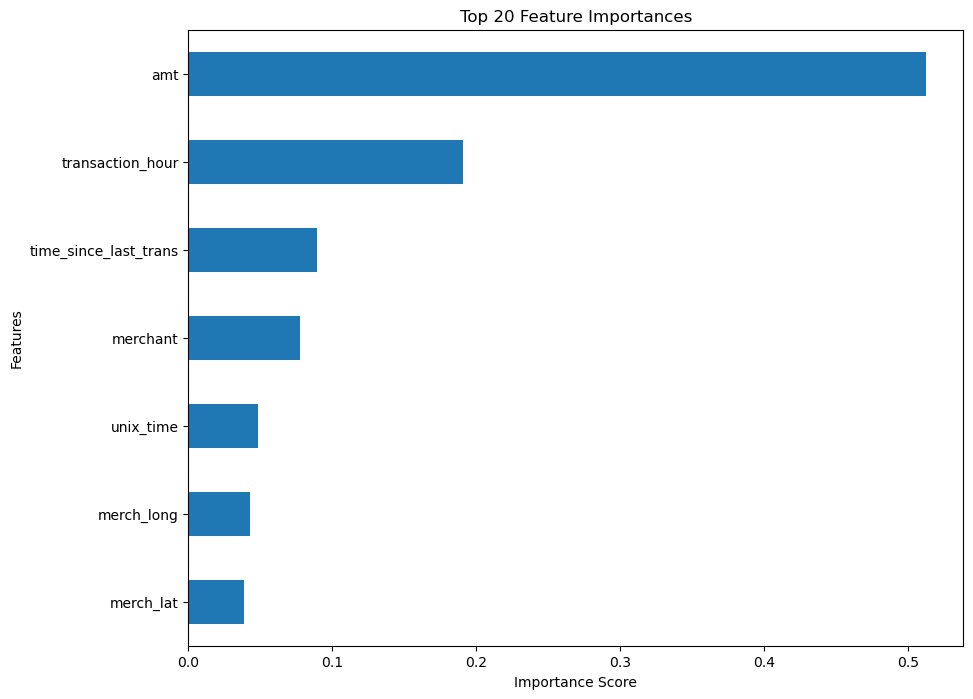

In [9]:
# Fit a preliminary Random Forest to determine feature importances
prelim_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
prelim_rf.fit(X_train_sampled, Y_train_sampled)

# Get feature importances
importances = prelim_rf.feature_importances_
feature_names = X_train_sampled.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Select top N features (e.g., top 30)
top_features = feature_importances.head(30).index.tolist()

# Reduce the dataset to top features
X_train_selected = X_train_sampled[top_features]
X_test_selected = X_test_sampled[top_features]

In [10]:
# List of top feature names
print(top_features)

# Identify categorical feature indices within the top_features
# Example: Suppose 'sex', 'city', 'zip', 'job', 'merchant', 'state_*', 'category_*', 'transaction_day_of_week_*' are in top_features

categorical_features = [
    top_features.index('merchant'),
    top_features.index('merch_long'),
    top_features.index('merch_lat'),
    top_features.index('time_since_last_trans'),
    top_features.index('unix_time'),
    top_features.index('amt'),
    top_features.index('transaction_hour')
]

# Ensure that the indices are correctly identified
print("Categorical feature indices within top_features:", categorical_features)

['amt', 'transaction_hour', 'time_since_last_trans', 'merchant', 'unix_time', 'merch_long', 'merch_lat']
Categorical feature indices within top_features: [3, 5, 6, 2, 4, 0, 1]


In [11]:
# Check for NaNs in the sampled training data
print("NaNs in X_train_selected:")
print(X_train_selected.isna().sum())

print("\nNaNs in Y_train_sampled:")
print(Y_train_sampled.isna().sum())

# Check for NaNs in the sampled testing data
print("\nNaNs in X_test_selected:")
print(X_test_selected.isna().sum())

print("\nNaNs in Y_test_sampled:")
print(Y_test_sampled.isna().sum())

NaNs in X_train_selected:
amt                      0
transaction_hour         0
time_since_last_trans    0
merchant                 0
unix_time                0
merch_long               0
merch_lat                0
dtype: int64

NaNs in Y_train_sampled:
0

NaNs in X_test_selected:
amt                      0
transaction_hour         0
time_since_last_trans    0
merchant                 0
unix_time                0
merch_long               0
merch_lat                0
dtype: int64

NaNs in Y_test_sampled:
0


In [12]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', n_jobs=-1)

# Apply SMOTE to the training data
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_sampled, Y_train_sampled)

# Verify the class distribution
print("Class distribution after SMOTE:")
print(Y_train_resampled.value_counts())

Class distribution after SMOTE:
fraudulence
0.0    118357
1.0    118357
Name: count, dtype: int64


C:\Users\walde\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [13]:
X_train_resampled.columns

Index(['unix_time', 'merchant', 'amt', 'merch_lat', 'merch_long',
       'transaction_hour', 'time_since_last_trans'],
      dtype='object')

In [14]:
# Reindex the test set to match the training set's column order
X_test_sampled = X_test_sampled.reindex(columns=X_train_resampled.columns)
X_test_sampled.columns

Index(['unix_time', 'merchant', 'amt', 'merch_lat', 'merch_long',
       'transaction_hour', 'time_since_last_trans'],
      dtype='object')

In [15]:
rfc = make_pipeline(RandomForestClassifier(n_estimators=200, criterion='entropy', min_samples_split=10, bootstrap=True, 
                                           min_samples_leaf=4, class_weight='balanced_subsample', random_state=42, n_jobs=-1))

rfc.fit(X_train_resampled, Y_train_resampled)

# Reindex the test set to match the training set's column order
X_test_sampled = X_test_sampled.reindex(columns=X_train_resampled.columns)

y_proba = rfc.predict_proba(X_test_sampled)[:, 1]
threshold = 0.62
pred = (y_proba >= threshold).astype(int)
#pred = rfc.predict(X_test_sampled)

accuracy = accuracy_score(Y_test_sampled, pred)
report = classification_report(Y_test_sampled, pred)
matrix = confusion_matrix(Y_test_sampled, pred)

print(accuracy)
print(report) 
print(matrix)

0.9959203100564357
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29280
         1.0       0.54      0.69      0.61       134

    accuracy                           1.00     29414
   macro avg       0.77      0.84      0.80     29414
weighted avg       1.00      1.00      1.00     29414

[[29202    78]
 [   42    92]]


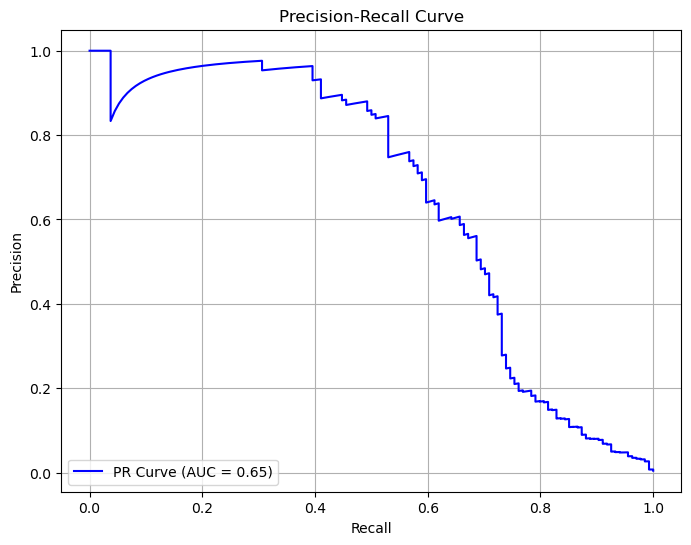

AUC-PR (Precision-Recall AUC): 0.65
Optimal Threshold for PR (Maximizing F1 Score): 0.8856


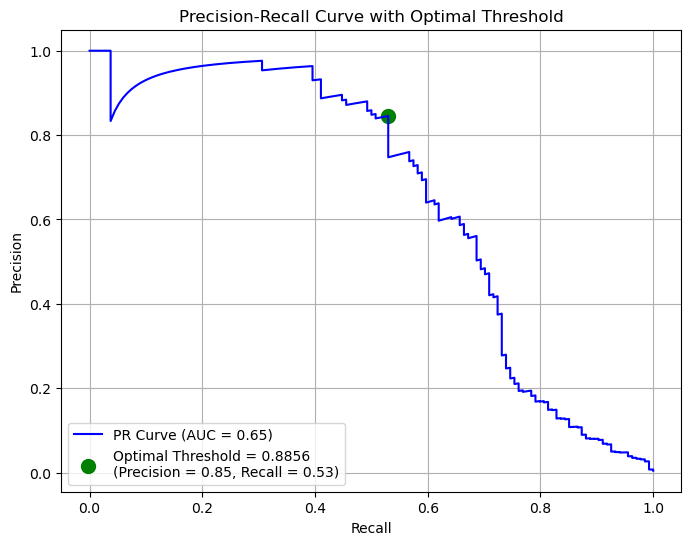

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Obtain predicted probabilities for the positive class (assuming class '1' is positive)
y_proba = rfc.predict_proba(X_test_sampled)[:, 1]

# ---------------------------
# 1. Compute Precision-Recall Curve and AUC-PR
# ---------------------------

# Compute precision, recall, and thresholds for the PR curve
precision, recall, thresholds_pr = precision_recall_curve(Y_test_sampled, y_proba)

# Calculate AUC-PR
auc_pr = average_precision_score(Y_test_sampled, y_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Print AUC-PR value
print(f"AUC-PR (Precision-Recall AUC): {auc_pr:.2f}")

# ---------------------------
# 2. Find the Optimal Threshold for PR Curve
# ---------------------------

# Compute the F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Ignore the last threshold (always 0 in sklearn's implementation)
thresholds_pr = np.append(thresholds_pr, 1.0)  # Adding 1 to match the length of precision/recall

# Find the index of the maximum F1 score
optimal_idx_pr = np.argmax(f1_scores)

# Get the optimal threshold for PR
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]

# Print the optimal threshold for PR
print(f"Optimal Threshold for PR (Maximizing F1 Score): {optimal_threshold_pr:.4f}")

# ---------------------------
# 3. Visualize Optimal Threshold on Precision-Recall Curve
# ---------------------------

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {auc_pr:.2f})')
plt.scatter(recall[optimal_idx_pr], precision[optimal_idx_pr], color='green', marker='o',
            label=f'Optimal Threshold = {optimal_threshold_pr:.4f}\n(Precision = {precision[optimal_idx_pr]:.2f}, Recall = {recall[optimal_idx_pr]:.2f})', s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [17]:
# Check original class distribution in the full training data
print("Original Training Class Distribution:")
print(Y_train_full.value_counts())

# After Sampling
print("\nSampled Training Class Distribution:")
print(Y_train_sampled.value_counts())

Original Training Class Distribution:
fraudulence
0.0    1183574
1.0       5154
Name: count, dtype: int64

Sampled Training Class Distribution:
fraudulence
0.0    118357
1.0       515
Name: count, dtype: int64


In [ ]:
#from pipeline2 import Pipeline

#pl = Pipeline(version='Random Forest')
#pl2 = Pipeline(version='Logistic Regression')
#pl3 = Pipeline(version='Extra Trees')

input_data = {
    'trans_date_trans_time': '2020-09-03 00:31:20',  # Example date and time of transaction
    'cc_num': 213157767990030,  # Example credit card number
    'unix_time': 1378168000,  # Example Unix timestamp (this corresponds to the transaction date)
    'merchant': 'Heidenreich PLC',  # Example merchant name
    'category': 'shopping_pos',  # Example transaction category
    'amt': 186.45,  # Example transaction amount
    'merch_lat': 42.284460,  # Example merchant latitude
    'merch_long': -108.456133  # Example merchant longitude
}

input_data_2 = {
    'trans_date_trans_time': '2019-01-02 01:06:37',
    'cc_num': 4613314721966,
    'unix_time': 1325466397.0,
    'merchant': 'fraud_Rutherford-Mertz',  # Fraudulent merchant
    'category': 'grocery_pos',  # Category
    'amt': 281.06,  # Transaction amount
    'merch_lat': 36.430124,  # Merchant latitude
    'merch_long': -81.179483  # Merchant longitude
}

# Run the pipeline's predict function with the synthetic input
prediction = rfc.predict(input_data)
print(f"Random Forest Example 1 Prediction: {prediction}")

#prediction = pl2.predict(input_data)
#print(f"Logistic Regression Example 1 Prediction: {prediction}")

#prediction = pl3.predict(input_data)
#print(f"Extra Trees Example 1 Prediction: {prediction}")

prediction = rfc.predict(input_data_2)
print(f"Random Forest Example 2 Prediction: {prediction}")

#prediction = pl2.predict(input_data_2)
#print(f"Logistic Regression Example 2 Prediction: {prediction}")

#prediction = pl3.predict(input_data_2)
#print(f"Extra Trees Example 2 Prediction: {prediction}")

In [ ]:
pl.get_history('prediction_history.csv')